# Hyper

A script to detect the most hyped (popular) bands of a festival

In [1]:
# https://www.dataquest.io/blog/python-pandas-databases/

In [1]:
import sqlite3
import pandas as pd
import string
import unicodedata
import numpy as np

## Load Data

In [2]:
# Setup sqlite
sqlite_file = 'hyper.db'

# Connect to the database sqlite file
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [17]:
# get list of bands from db
bands = pd.read_sql_query("SELECT * FROM Bands;", connection)
print("{} bands read".format(len(bands)))
#bands.head()

268 bands read


In [4]:
# read ALL tweets from db
all_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw", connection)
print("{} tweets in db".format(len(all_tweets)))

3430 tweets in db


In [5]:
# read ONLY tweets that have to be processed
tweets_to_process = pd.read_sql_query("SELECT * FROM TweetsRaw WHERE processed IS NULL", connection)
print("{} tweets to be processed".format(len(tweets_to_process)))

1690 tweets to be processed


In [6]:
# read ONLY tweets that have to be processed
#tweets_to_process = pd.read_sql_query("SELECT tr.* FROM TweetsRaw AS tr \
#                                       LEFT JOIN BandTweets AS bt ON tr.id == bt.tweetRawId \
#                                       WHERE bt.tweetRawId IS NULL", connection)
#print("{} tweets to process".format(len(tweets_to_process)))

In [7]:
# tweets_to_process = tweets_to_process.head(50)
# print("{} tweets to process (!!!REMOVE!!!)".format(len(tweets_to_process)))

## Partition per band

Look for tweets talking about bands and re-create data structure in a band-centered way

In [8]:
def extract_bands(tweet):
    """
    Function that extracts the bands from a tweet text
    Returns a list of bands
    """
    
    # init list to return
    bands_in_tweet = []
    
    # loop all bands and check of any of the written forms is present in the tweet text
    for i, b in bands.iterrows():
                
        # set different band names writing possibilities
        bandname = b['name']
        bandname_lowercase = bandname.lower()
        bandname_lowercase_no_spaces = ''.join(bandname_lowercase.split())
        bandname_lowercase_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase) if unicodedata.category(c) != 'Mn'))
        bandname_lowercase_no_spaces_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase_no_spaces) if unicodedata.category(c) != 'Mn'))

        # check if any of the forms is in the tweet text
        if any(s in tweet['tweetText'].lower() for s in [bandname_lowercase, bandname_lowercase_no_spaces, bandname_lowercase_no_accents, bandname_lowercase_no_spaces_no_accents, b['twitterName']]):
            bands_in_tweet.append({"id": b['id'], "codedName": b['codedName']})

    return bands_in_tweet

In [9]:
def band_partition(tweet):
    """
    Function that reads a single tweet info and adds into a list the tweet information partitioned by bands.
    I.e. If a tweet mentions 2 bands, it adds a list of 2 dicts with the tweet info
    """
    
    # loop all bands and add an entry to the list
    for b in tweet['bands']:
        new_band_tweets_list.append({\
                                 "tweetRawId" : tweet['id'],\
                                 "createdAt" : tweet['createdAt'],\
                                 "storedAt" : tweet['storedAt'],\
                                 "bandId" : b['id'],\
                                 "bandCodedName" : b['codedName'],\
                                 "favsCount" : tweet['favsCount'],\
                                 "rtsCount" : tweet['rtsCount'],\
                                 "language" : tweet['language'],\
                                 "userId" : tweet['userId'],\
                                 "userFriendsCount" : tweet['userFriendsCount'],\
                                 "userFollowersCount" : tweet['userFollowersCount'],\
                                 "userStatusesCount" : tweet['userStatusesCount'],\
                                 "userFavsCount" : tweet['userFavsCount'],\
                                 "userLocation" : tweet['userLocation']\
                                })
    
    # Mark TweetsRaw as processed
    db.execute("UPDATE TweetsRaw SET processed = 1 WHERE id == {}".format(tweet.id))
    connection.commit()

In [10]:
if(tweets_to_process.shape[0] > 0):

    # extract bands for each tweet
    tweets_to_process['bands'] = tweets_to_process.apply(extract_bands, axis=1)

    # construct the list of tweets per band
    new_band_tweets_list = []
    tweets_to_process.apply(band_partition, axis=1);

    # create a dataframe from the previous list
    new_band_tweets = pd.DataFrame.from_dict(new_band_tweets_list)
    print("{} band-tweets".format(new_band_tweets.shape[0]))
else:
    new_band_tweets = pd.DataFrame([])
    print("No new tweets to process")

522 band-tweets


In [11]:
# Persist extracted tweets in DB (BandTweets table)
if(new_band_tweets.shape[0] > 0):
    new_band_tweets[['tweetRawId', 'bandId']].to_sql('BandTweets', connection, if_exists='append')
    print("{} new band tweets persisted".format(new_band_tweets.shape[0]))
else:
    print("No new band tweets to persist")

522 new band tweets persisted


## Explore Band-Tweet Data

In [30]:
# Construct a dataframe joining data from TweetsRaw and BandTweets
band_tweets = pd.read_sql_query("SELECT bt.bandId, \
                                        b.name AS bandName, \
                                        b.codedName AS bandCodedName, \
                                        b.headLevel AS headLevel, \
                                        b.popularity AS popularity, \
                                        tr.* \
                                 FROM BandTweets AS bt\
                                 LEFT JOIN TweetsRaw AS tr ON bt.tweetRawId == tr.id \
                                 LEFT JOIN Bands AS b ON bt.bandId == b.id", connection)
print("{} band tweets in db".format(band_tweets.shape[0]))

981 band tweets in db


In [31]:
# Count tweets per band
print(band_tweets.groupby('bandCodedName').size().sort_values(ascending=False))

bandCodedName
frankocean            65
!!!                   56
arcadefire            50
tie                   46
grandaddy             35
slayer                30
teenagefanclub        24
boniver               23
aphextwin             21
valius                19
pavvla                18
thezombies            18
pond                  17
belako                17
solange               16
gas                   16
elzasoares            15
chkchkchk             14
thecrabapples         14
runthejewels          13
kinggizzard           13
keems                 13
thexx                 13
museless              12
glassanimals          12
macdemarco            11
juliajacklin          11
angelolsen            10
astronautproject       9
skepta                 9
                      ..
againstme!             1
weyesblood             1
abdullarashim          1
7notas7colores         1
shao                   1
moscoman               1
silentjames            1
cocainepiss            1
jeremyjay  

In [33]:
# Count measures of a given band
bandCodedName = 'arcadefire'
print("Tweets about {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').size()[bandCodedName]))
print("Total Favs of {}: {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['favsCount'][bandCodedName]))
print("Total RTs of {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['rtsCount'][bandCodedName]))

Tweets about arcadefire:  50
Total Favs of arcadefire: 72
Total RTs of arcadefire:  39


## Explore Band-Tweet Timelines

In [34]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

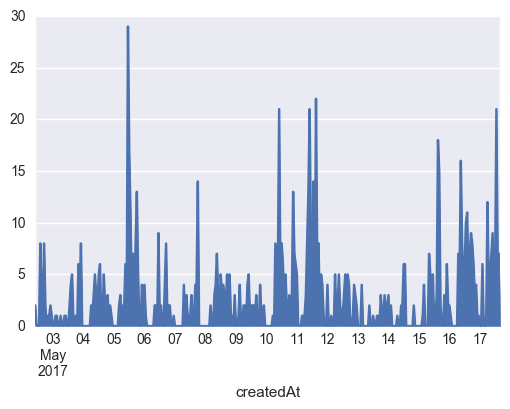

In [23]:
# timeline of tweets - all bands
# https://chrisalbon.com/python/pandas_group_data_by_time.html
band_tweets['createdAt'] = pd.to_datetime(band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
band_tweets.index = band_tweets['createdAt']
band_tweets.resample('H').count()['bandId'].plot(kind='area')

/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


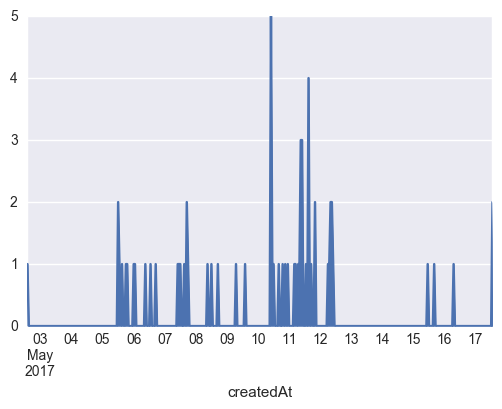

In [25]:
# timeline of tweets - single band
bandCodedName = 'frankocean'
single_band_tweets = band_tweets[band_tweets['bandCodedName'] == bandCodedName]
single_band_tweets['createdAt'] = pd.to_datetime(single_band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
single_band_tweets.index = single_band_tweets['createdAt']
single_band_tweets.resample('H').count()['bandId'].plot(kind='area')

## Hyper Score & Ranking

Create the dataframe with one row per band and all the metrics associated

In [40]:
# group and sum band tweets by band
band_hypes = band_tweets.groupby(['bandCodedName', 'bandName', 'bandId', 'headLevel', 'popularity']).sum()

# insert a column with the number of tweets
band_hypes['tweets'] = band_tweets.groupby(['bandCodedName', 'bandName', 'bandId', 'headLevel', 'popularity']).size()

# reset the index created in the group by
band_hypes = band_hypes.reset_index()

# delete not needed columns
del band_hypes['id']
del band_hypes['userFriendsCount']
del band_hypes['userFollowersCount']
del band_hypes['userStatusesCount']
del band_hypes['userFavsCount']
del band_hypes['processed']

# rename and re-order columns
band_hypes = band_hypes.rename(columns={'favsCount':'favs', 'rtsCount':'retweets'})
band_hypes = band_hypes[['bandId', 'bandCodedName', 'bandName', 'headLevel', 'popularity', 'tweets', 'favs', 'retweets']]

### BF-IBP (TF-IDF revisited)
Band Frequency - Inverse BAnd Popularity
- term => band
- document => all tweets
- corpus of documents => X

#### TF: Term Frequency (normalized)
Definition:
- Measures how frequently a term occurs in a document
- Measures how frequently a band is mentioned in a set of tweets

Computation:
- number of times term t appears in a document / total number of terms in the document
- number of tweets talking about that band / total number of tweets

#### IDF: Inverse Document Frequency
Definition:
- Measures how important a term
- Measures how important a band is

Computation:
- log( total number of documents / number of documents with term t in it)
- we don't have other documents so we need another way to measure how important a band is...
  - we will consider the level of headliner of the band (according to the font size used in the festival lineup poster)
  - 5 levels: 1 (top line-up) to 5 (bottom line-up)

In [51]:
# Compute BF-IBP (Band Frequency - Inverse Band Popularity)
bf_numerator = band_hypes['tweets']*(1 + band_hypes['favs'] + band_hypes['retweets'])
band_hypes['bf_ibp'] = (bf_numerator/bf_numerator.sum()) * np.log(band_hypes['popularity'].astype(float) + 1)

In [52]:
# band_hypes.sort_values(by='tweets', ascending=False).head(10)
band_hypes.sort_values(by='bf_ibp', ascending=False).head(10)

,bandId,bandCodedName,bandName,headLevel,popularity,tweets,favs,retweets,bf-ibp,bf_ibp
49,75,grandaddy,Grandaddy,3,54,35,36,254,0.628324,0.628324
40,66,frankocean,Frank Ocean,1,87,65,52,58,0.497306,0.497306
124,203,teenagefanclub,Teenage Fanclub,2,46,24,1,327,0.468006,0.468006
0,1,!!!,!!!,3,50,56,45,67,0.383026,0.383026
134,265,tie,Tiê,5,52,46,50,80,0.368315,0.368315
13,21,arcadefire,Arcade Fire,1,68,50,72,39,0.365020,0.365020
35,59,elzasoares,Elza Soares,3,47,15,17,140,0.141241,0.141241
96,158,pavvla,PAVVLA,4,35,18,14,95,0.109230,0.109230
133,229,thezombies,The Zombies,3,59,18,13,69,0.094168,0.094168
120,197,solange,Solange,1,68,16,14,57,0.075090,0.075090


In [50]:
# Persist band_hypes to DB
sqlite_file_write = 'hyper.db'
connection_write = sqlite3.connect(sqlite_file_write)
db = connection_write.cursor()
band_hypes[['bandId','tweets','favs','retweets','bf_ibp']].to_sql("BandsHype", connection_write, if_exists="replace", index=False)